In [11]:
import sys
#!{sys.executable} -m pip install ipynb

import numpy as np
import torch
from torch import nn, distributions
from scipy.spatial.distance import cdist
from scipy.stats import norm
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.FloatTensor)

# Bayesian Optimization from scratch

In the last lecture we have seen how to use Gaussian Process for regression.In this lecture we are going to see how to use them for an optimization problem. 

The general setting of an optimization problem is that we have a certain objective function $f(x)$ that we want to maximize. Mathematicallly, we are interested in

$$x^{*} = \arg \max_{x \in X} f(x)$$

where $X$ is often a compact subset of $\mathbb{R}$. We consider a particular case of optimization problem: we have no analytical expression for the function of our interest $f$ and we cannot also compute the gradient with respect of $x$. Therefore we cannot use usual methods like gradient ascent (or gradient descent on $-f(x)$) to find the maximum. We are assuming a *black box* function $f$, that means, we can only evaluate the function at any query point $x$ in the domain. In other words we can observe the function $f$ only through unbiased and noisy observations $y$. In addition to that, evaluating the unknown function is expensive, either in term of computation or time, and we have only a limited budget.

In the lecture, we have seen that when we are dealing with these kinds of functions, Bayesian Optimization is a powerful sequential strategy to find the maximum/minimum. It has two main ingredients:

1. A probabilistic model over functions
2. An acquisition function

As probabilistic model, we are going to use a Gaussian Process. We need two functions, that you have also seen in the previous exercise session. One function `fit_predictive_gp` that fits the Gaussian Process and one function `optimize_gp_hyperparameters` that finds the value of lengthscale, output variance, and noise variance that maximize the log-likelihood plus the log prior. Since this step would be a repetition of the previous exercise session, we will provide these functions (with comments) for you. We are also providing the code for the dataset of the last lecture to show you that the functions works.

<font color='blue'> Tasks:

1. You should implement a function that fit a Gaussian Process (following the algorithm you have learnt last lecture) `fit_predictive_GP(X, y, Xtest, lengthscale, kernel_variance, noise_variance)` (you should also reimplement the squared exponential kernel).  <font color='Green'>( Note that we are already giving you a function that optimizes the hyperparameters of the kernel. It is done in PyTorch using Gradient Descent. Also note, that this is is not the way that the Bayesian Optimization library implements this.) 


In [2]:
def squared_exponential_kernel(x, y, lengthscale, variance):
    '''
    Function that computes the covariance matrix using a squared-exponential kernel
    '''
    # pair-wise distances, size: NxM
    sqdist = cdist(x.reshape(-1,1), y.reshape(-1,1), 'sqeuclidean')
    # compute the kernel
    cov_matrix =  variance * np.exp(-sqdist / (2*lengthscale**2))   # NxM
    return cov_matrix


def fit_predictive_GP(X, y, Xtest, lengthscale, kernel_variance, noise_variance):
    '''
    Function that fit the Gaussian Process. It returns the predictive mean function and
    the predictive covariance function. It follows step by step the algorithm on the lecture
    notes
    '''    
    X, y, Xtest = np.array(X), np.array(y), np.array(Xtest)
    N = len(X)
    K = squared_exponential_kernel(X, X, lengthscale, kernel_variance)
    Ks = squared_exponential_kernel(X, Xtest, lengthscale, kernel_variance)
    Kss = squared_exponential_kernel(Xtest, Xtest, lengthscale, kernel_variance)
    # compute the cholesky decomposition
    L = np.linalg.cholesky(K + noise_variance * np.eye(N))
    
    # compute alpha
    alpha = np.linalg.solve(L.T, np.linalg.pinv(L) @ y)
    # compute the mean function
    mu = Ks.T @ alpha
    # compute v
    v = np.linalg.solve(L, Ks)
    # compute the covariance
    covariance = Kss - (v.T @ v)
    
    return mu, covariance


# I am using PyTorch to define the optimization function, it can be done in different other ways.
# It is not the best way to implement it, I suppose
def optimize_GP_hyperparams(Xtrain, ytrain, optimization_steps, learning_rate, mean_prior, prior_std):
    '''
    Methods that run the otpimization of the hyperparams of our GP. We will use
    Gradient Descent because it takes to much time to run grid search at each step
    of bayesian optimization. We use a different definition of the kernel to make the
    optimization more stable

    :param X: training set points
    :param y: training targets
    :return: values for lengthscale, output_var, noise_var that maximize the log-likelihood
    '''
    
    # we are re-defining the kernel because we need it in PyTorch
    def squared_exponential_kernel_torch(x, y, _lambda, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        sqdist = torch.pow(x - y, 2)
        k = variance * torch.exp(-0.5 * sqdist * (1/_lambda**2))  # NxM
        return k

    X = np.array(Xtrain).reshape(-1,1)
    y = np.array(ytrain).reshape(-1,1)
    N = len(X)

    # tranform our training set in Tensor
    Xtrain_tensor = torch.from_numpy(X).float()
    ytrain_tensor = torch.from_numpy(y ).float()
    # we should define our hyperparameters as torch parameters where we keep track of
    # the operations to get hte gradients from them
    _lambda = nn.Parameter(torch.tensor(1.), requires_grad=True)
    output_variance = nn.Parameter(torch.tensor(1.), requires_grad=True)
    noise_variance = nn.Parameter(torch.tensor(.5), requires_grad=True)

    # we use Adam as optimizer
    optim = torch.optim.Adam([_lambda, output_variance, noise_variance], lr=learning_rate)

    # optimization loop using the log-likelihood that involves the cholesky decomposition 
    nlls = []
    lambdas = []
    output_variances = []
    noise_variances = []
    iterations = optimization_steps
    for i in range(iterations):
        assert noise_variance >= 0, f"ouch! {i, noise_variance}"
        optim.zero_grad()
        K = squared_exponential_kernel_torch(Xtrain_tensor, Xtrain_tensor, _lambda,
                                                output_variance) + noise_variance * torch.eye(N)
        
        L = torch.cholesky(K)
        _alpha_temp, _ = torch.solve(ytrain_tensor, L)
        _alpha, _ = torch.solve(_alpha_temp, L.t())
        nll = N / 2 * torch.log(torch.tensor(2 * np.pi)) + 0.5 * torch.matmul(ytrain_tensor.transpose(0, 1),
                                                                              _alpha) + torch.sum(torch.log(torch.diag(L)))

        # we have to add the log-likelihood of the prior
        norm = distributions.Normal(loc=mean_prior, scale=prior_std)
        prior_negloglike =  torch.log(_lambda) - torch.log(torch.exp(norm.log_prob(_lambda)))

        nll += 0.9 * prior_negloglike
        nll.backward()

        nlls.append(nll.item())
        lambdas.append(_lambda.item())
        output_variances.append(output_variance.item())
        noise_variances.append(noise_variance.item())
        optim.step()

        # projected in the constraints (lengthscale and output variance should be positive)
        for p in [_lambda, output_variance]:
            p.data.clamp_(min=0.0000001)

        noise_variance.data.clamp_(min=1e-5, max= 0.05)

        
    return _lambda.item(), output_variance.item(), noise_variance.item()

<font color='Blue'> Task:
1. Here you check if you Gaussian Process regression algotihm works as expected. (Note, we are giving the parameters of the prior of the lengthscale. If you need clarification in how we are optimizing the kernel parameters, feel free to ask)

Xtrain shape (50, 1)
ytrain shape (50, 1)


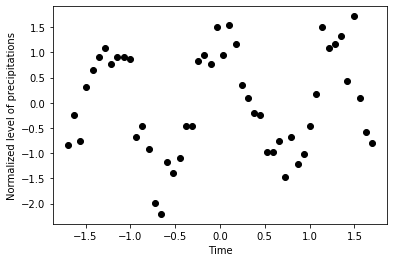

Optimized parameters: 0.29848161339759827 1.574049472808838 0.05000000074505806


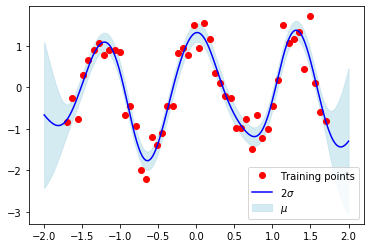

In [3]:
## safety check: we try to run the code in the dataset of last lecture and see if it works
from scipy.io import loadmat

## We load the data and use only some of them.
## We subsample the data, which gives us N pairs of (x, y)
M = 1000
data = loadmat('weather_dataset.mat')
# sampling part 
Xtrain = np.arange(0, M, 20)
ytrain = data['TMPMAX'][Xtrain]
N = len(ytrain)
Xtrain = Xtrain.reshape(-1,1)

# print dataset information
print('Xtrain shape', Xtrain.shape)
print('ytrain shape', ytrain.shape)

# also in this case we standardize the data to have zero mean and unit variance
Xtrain = (Xtrain - np.mean(Xtrain)) / np.std(Xtrain)
ytrain = (ytrain - np.mean(ytrain)) / np.std(ytrain)

# and plot it
plt.plot(Xtrain, ytrain, 'o', color='black')
plt.ylabel('Normalized level of precipitations')
plt.xlabel('Time')
plt.show()

# we shall also define the test set, that is the range of XTest point we want to 
# use to compute the mean and the variance
Xtest = np.linspace(-2, 2, M).reshape(-1,1)

## we have to define the mena and variance of the log-normal distribution for the lengthscale prior 
prior_mean = -1.5
prior_std = 0.6
np.shape(Xtest)

lengthscale, output_var, noise_var = optimize_GP_hyperparams(Xtrain, ytrain, 500, 5e-3, prior_mean, prior_std)
print('Optimized parameters:', lengthscale, output_var, noise_var)

# we can fit the GP that use the hyperparameters found above
mu, covariance = fit_predictive_GP(Xtrain, ytrain, Xtest, lengthscale, output_var, noise_var)
std = np.sqrt(np.diag(covariance))
plt.plot(Xtrain, ytrain, 'ro', label='Training points')
plt.gca().fill_between(Xtest.flat, mu.reshape(-1) - 2 * std, mu.reshape(-1) + 2 * std,  color='lightblue', alpha=0.5, label=r"$\mu$")
plt.plot(Xtest, mu, 'blue', label=r"$2\sigma$")
plt.legend()
plt.show() 


## Acquisition Function

The second key ingredient of Bayesian Optimization are **acquisition functions**. These auxiliary functions uses the information from the probabilistic model to trade off exploration and exploitation. Indeed, the next point where we are going to query the unknown objective function is the one that maximize the acquisition function. 

We have seen three different functions in the lecture: *Probability of Improvement*, *Expected Improvement*, and *Upper Confidence Bound*. We are going to repeat their formulation here.

### Probability of improvement

The probability of improvement try to measure for each point $x \in \mathcal{X}$, where $\mathcal{X}$ is our space of interest, the probability that $f(x)$ is higher than the current best sample $f(x^+)$. 

The mathematica formulation is given by:

\begin{align}
\text{PI}(\mathbf{x}) &= \text{P}(f(\mathbf{x}) \geq f(\mathbf{x}^+) + \xi) = \\
               &= \Phi\biggl(\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})}\biggr)
\end{align}

where $\xi$ is an hyperparameter left to the user, that trades off exploration and exploitation and $\Phi$ is the cumulative distribution function of the Gaussian distribution.

### Expected improvement

Expected improvement tries to quantify the amount of improvement for each  $x \in \mathcal{X}$ with respect the current best sample. Using a Gaussian Process as probabilistic model, this is given by:

\begin{align}
\text{EI}(\mathbf{x}) = \left\{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
(\mu(\mathbf{x}) - f(\mathbf{x}^+)) \Phi(Z) + \sigma(\mathbf{x})  \phi(Z) \hspace{1.66cm} \text{if } \sigma(\mathbf{x}) > 0\\ 
0  \hspace{7.38cm} \text{if } \sigma(\mathbf{x}) > 0
\end{array}
\right.
\end{align}

where $Z = \frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi }{\sigma(\mathbf{x})}$ and $\Phi$ is the cumulative distribution function and $\phi$ the probability density function of the standard Gaussian distribution.


### Gaussian Process Upper Confidence Bound

The Gaussian Process - Upper Confidence bound (GP-UCB) trades off exploration and exploration by using directly the predictive mean and variance from the Gaussian Process. While its first formulation is pretty easy

\begin{align}
\text{UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \kappa \sigma (\mathbf{x})
\end{align}

where $\kappa$ is the trade-off parameters we have to choose beforehand, in recent publication a new formulation has been considered. Additionally, it has been proven for specific parameters, the new formulation leads to no regret asymptotically, which means that it gets the true maximum of the function. For this reason, we are going to implement the new formulation, which is defined as:

\begin{align}
\text{GP-UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \sqrt{\nu \beta_t} \sigma (\mathbf{x})
\end{align}

where $\beta_t$ depends on the iteration $t$ and $\nu$ is left to the user. It has been proven that with $\nu = 1$ and $\beta_t = 2 \log(\frac{t^{\frac{d}{2}+2}\pi^2}{3 \delta})$,where $t$ is the iteration number, $d$ is the dimensionality of the problem, and $\delta \leq 0$ is left to the user, we would have *no-regret* asymptotically.

A simple approximation, is given by: 

\begin{align}
\text{GP-UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \epsilon \log(t) \sigma (\mathbf{x})
\end{align}

<font color='blue'> Tasks:
1. Implement the three different acquisition functions in Python.
2. We provide you some points, try to fit a Gaussian Process on this points (remember to optimize the hyperparameters first), and compute the acquisition function. Code is provided to plot both the GP and the different acquisition functions. Try to understand what happens when you change the value of the trade-off hyperparameter $\xi$ or $\nu$ (or $\epsilon$). To help you with this plots with varying values of the hyperparameter are provided in the same plot.
    

In [4]:
# we want to define the function over all the points in the
# range of interest, defined as X
def probability_of_improvement(current_best, mean, std, eps):
    '''
    Thus function implements the probability of improvement acquisition function.
    It implements
        PI(x) = P(f(x) >= f(x^+))
            since we consider f(x^+) = mu^+ + eps we have
              = Phi ( (mu - mu^+ - eps) / sigma )
    :param current_best: this is the current max of the unknown function: mu^+
    :param mean: this is the mean function from the GP over the considered set of points
    :param std: this is the std function from the GP over the considered set of points
    :param eps: small value added to avoid corner case
    :return: the value of this acquisition function for all the points
    '''
    # since std coan be 0, to avoid an error, we add a small value in the denominator (like +1e-9)
    Z = (mean - current_best - eps) / (std + 1e-9)
    PI = norm.cdf(Z) 
    return PI 


def expected_improvement(current_best, mean, std, eps):
    '''
    It implements the following function:

            | (mu - mu^+ - eps) Phi(Z) + sigma phi(Z) if sigma > 0
    EI(x) = |
            | 0                                       if sigma = 0

            where Phi is the CDF and phi the PDF of the normal distribution
            and
            Z = (mu - mu^+ - eps) / sigma

    :param current_best: this is the current max of the unknown function: mu^+
    :param mean: this is the mean function from the GP over the considered set of points
    :param std: this is the std function from the GP over the considered set of points
    :param eps: small value added to avoid corner case
    :return: the value of this acquisition function for all the points
    '''

    # start by computing the Z as we did in the probability of improvement function
    # to avoid division by 0, add a small term eg. np.spacing(1e6) to the denominator
    Z = (mean - current_best - eps) / (std + 1e-9)
    # now we have to compute the output only for the terms that have their std > 0
    N = len(std)
    EI = np.empty(N)
    
    for i in range(N):
        if std[i] == 0:
            EI[i] = 0
        else:
            EI[i] = (Z[i]*std[i]) * norm.cdf(Z[i]) + std[i] * norm.pdf(Z[i])
    return EI


def GP_UCB_original(mean, std, t, dim = 1.0, v = 1.0, delta = .1):
    '''
    Implementation of the Gaussian Process - Upper Confident Bound:
        GP-UBC(x) = mu + sqrt(v * beta) * sigma

    where we are usinv v = 1 and beta = 2 log( t^(d/2 + 2) pi^2 / 3 delta)
    as proved in Srinivas et al, 2010, to have 0 regret.

    :param mean: this is the mean function from the GP over the considered set of points
    :param std: this is the std function from the GP over the considered set of points
    :param t: iteration number
    :param dim: dimension of the input space
    :param v: hyperparameter that weights the beta for the exploration-exploitation trade-off. If v = 1 and another
              condition, it is proved we have 0 regret
    :param delta: hyperparameter used in the computation of beta
    :return: the value of this acquisition function for all the points
    '''
    beta = 2 * np.log((t**((dim/2) + 2) * np.pi**2) / (3*delta))
    UCB = mean + np.sqrt(v * beta) * std
    return UCB



def GP_UCB_approx(mean, std, t, eps):
    '''
    Implementation of the Gaussian Process - Upper Confident Bound in a easy approximate way:
        GP-UBC(x) = mu + eps * log(t) * sigma

    we use the fact that beta ~ log(t)^2, so we have sqrt(v * log(t)^2) = log(t)*sqrt(v) ~ eps * log(t)

    :param mean: this is the mean function from the GP over the considered set of points
    :param std: this is the std function from the GP over the considered set of points
    :param t: iteration number
    :param eps: trade-off constant
    :return: the value of this acquisition function for all the points
    '''
    UCB = mean + eps * np.log(t) * std
    return UCB 

0.13181640207767487 4.140935897827148 0.05000000074505806


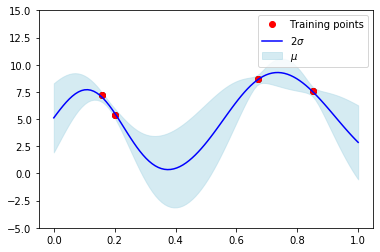

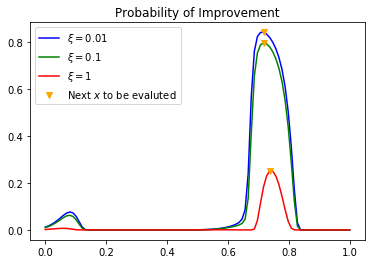

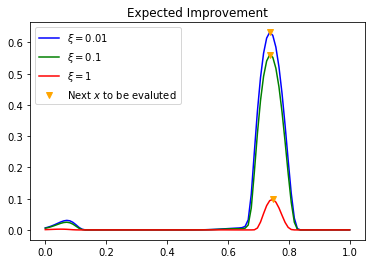

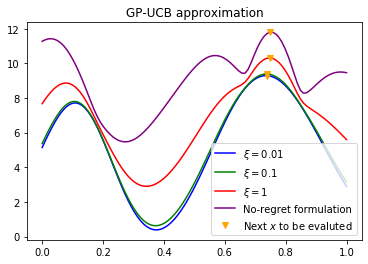

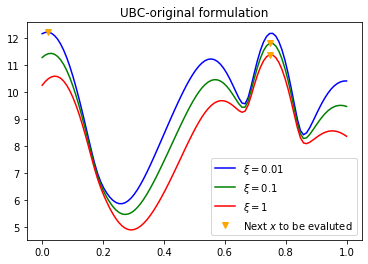

In [5]:
### testing example
# create toy dataset

# space of interest
xs = np.linspace(0,1,100)

X_samples = [0.16, 0.2, 0.67, 0.85]
#y_samples = [6.2, 6.5, 7.9, 9] # if you divide those by 10 it does not work!
y_samples = [7.2, 5.4, 8.7, 7.6]
## plot the dataset
plt.plot(X_samples, y_samples, 'o', color='black')
plt.xlim(0.,1.)
plt.ylim(-5.,15)

## prior for the lengthscale
prior_mean = -2
prior_std = 0.6

lengthscale, output_var, noise_var = optimize_GP_hyperparams(X_samples, y_samples, 1000, 5e-3, prior_mean, prior_std)
print(lengthscale, output_var, noise_var)

# we can fit the GP that use the hyperparameters found above
mu, covariance = fit_predictive_GP(X_samples, y_samples, xs, lengthscale, output_var, noise_var)
std = np.sqrt(np.diag(covariance))
plt.plot(X_samples, y_samples, 'ro', label='Training points')
plt.gca().fill_between(xs.flat, mu.reshape(-1) - 2 * std, mu.reshape(-1) + 2 * std,  color='lightblue', alpha=0.5, label=r"$\mu$")
plt.plot(xs, mu, 'blue', label=r"$2\sigma$")
plt.xlim([-0.05,1.05])
plt.legend()
plt.show() 


current_best = np.max(y_samples)
t = len(X_samples) + 1 
## compute the acquisition functions
## probability of improvement
acquisition_values1 = probability_of_improvement(current_best,  mu, std, 0.01)
next_x1 = np.argmax(acquisition_values1)
acquisition_values2 = probability_of_improvement(current_best,  mu, std, 0.1)
next_x2 = np.argmax(acquisition_values2)
acquisition_values3 = probability_of_improvement(current_best,  mu, std, 1)
next_x3 = np.argmax(acquisition_values3)

# plot them
plt.plot(xs, acquisition_values1, '-', color='blue', label =r'$\xi = 0.01$')
plt.plot(xs[next_x1], acquisition_values1[next_x1], 'v', color='orange')
plt.plot(xs, acquisition_values2, '-', color='green', label =r'$\xi = 0.1$')
plt.plot(xs[next_x2], acquisition_values2[next_x2], 'v', color='orange')
plt.plot(xs, acquisition_values3, '-', color='red', label =r'$\xi = 1.$')
plt.plot(xs[next_x3], acquisition_values3[next_x3], 'v', color='orange', label='Next $x$ to be evaluted')
plt.title('Probability of Improvement')
plt.legend()
plt.show()


## expected_improvement
acquisition_values1 = expected_improvement(current_best,  mu, std, 0.01)
next_x1 = np.argmax(acquisition_values1)
acquisition_values2 = expected_improvement(current_best,  mu, std, 0.1)
next_x2 = np.argmax(acquisition_values2)
acquisition_values3 = expected_improvement(current_best,  mu, std, 1)
next_x3 = np.argmax(acquisition_values3)

# plot them
plt.plot(xs, acquisition_values1, '-', color='blue', label =r'$\xi = 0.01$')
plt.plot(xs[next_x1], acquisition_values1[next_x1], 'v', color='orange')
plt.plot(xs, acquisition_values2, '-', color='green', label =r'$\xi = 0.1$')
plt.plot(xs[next_x2], acquisition_values2[next_x2], 'v', color='orange')
plt.plot(xs, acquisition_values3, '-', color='red', label =r'$\xi = 1.$')
plt.plot(xs[next_x3], acquisition_values3[next_x3], 'v', color='orange', label='Next $x$ to be evaluted')
plt.title('Expected Improvement')
plt.legend()
plt.show()


## GP-UCB approximate and no-regret
acquisition_values1 = GP_UCB_approx(mu, std, t, 0.01)
next_x1 = np.argmax(acquisition_values1)
acquisition_values2 = GP_UCB_approx(mu, std, t, 0.1)
next_x2 = np.argmax(acquisition_values2)
acquisition_values3 = GP_UCB_approx(mu, std, t, 1)
next_x3 = np.argmax(acquisition_values3)

acquisition_values_no_regret = GP_UCB_original(mu, std, t)
next_x_no_regret = np.argmax(acquisition_values_no_regret)

# plot them
plt.plot(xs, acquisition_values1, '-', color='blue', label =r'$\xi = 0.01$')
plt.plot(xs[next_x1], acquisition_values1[next_x1], 'v', color='orange')
plt.plot(xs, acquisition_values2, '-', color='green', label =r'$\xi = 0.1$')
plt.plot(xs[next_x2], acquisition_values2[next_x2], 'v', color='orange')
plt.plot(xs, acquisition_values3, '-', color='red', label =r'$\xi = 1.$')
plt.plot(xs[next_x3], acquisition_values3[next_x3], 'v', color='orange')
plt.plot(xs, acquisition_values_no_regret, '-', color='purple', label =r'No-regret formulation')
plt.plot(xs[next_x_no_regret], acquisition_values_no_regret[next_x_no_regret], 'v', color='orange', label='Next $x$ to be evaluted')
plt.title('GP-UCB approximation')
plt.legend()
plt.show()

## GP-UCB original formulation
acquisition_values1 = GP_UCB_original( mu, std, t, delta = 0.01)
next_x1 = np.argmax(acquisition_values1)
acquisition_values2 = GP_UCB_original(  mu, std, t, delta = 0.1)
next_x2 = np.argmax(acquisition_values2)
acquisition_values3 = GP_UCB_original(  mu, std, t, delta = 1)
next_x3 = np.argmax(acquisition_values3)

# plot them
plt.plot(xs, acquisition_values1, '-', color='blue', label =r'$\xi = 0.01$')
plt.plot(xs[next_x1], acquisition_values1[next_x1], 'v', color='orange')
plt.plot(xs, acquisition_values2, '-', color='green', label =r'$\xi = 0.1$')
plt.plot(xs[next_x2], acquisition_values2[next_x2], 'v', color='orange')
plt.plot(xs, acquisition_values3, '-', color='red', label =r'$\xi = 1.$')
plt.plot(xs[next_x3], acquisition_values3[next_x3], 'v', color='orange', label='Next $x$ to be evaluted')
plt.title('UBC-original formulation')
plt.legend()
plt.show()

### Put everything together

At this point you master both ingredients of Bayesian Optimization. In the last part of the previous exercise, you learned how to execute a single iteration of Bayesian Optimization. Therefore, repeating this step for $T$ times, would create the sequence strategy to find the maximum of an unknown objective function. 

We are going to simulate scenario in which you should maximize an unknown function using Bayesian Optimization.

<font color='blue'> Tasks:
1. We will give you a black box objective function that you want to maximize. You have to implement the Bayesian Optimization loop to perform the sequential search. At each step you should plot both the GP and the acquisition function. As in a real Bayesian Optimization setting, you do not have the mathematical formulation of the objective function. You only know that it is defined in $[0,2]$, ans you can query it using the followiong function `query_the_objective(x)`, which get as input the point $x \in \mathcal{X}$ that has to be evaluated. In addition to that, it has also a function to plot the real function, but you should use it only at the end, which is `plot_the_unknown_function()`. To compare the result you obtain, you can ask the "true" max by calling the function `get_the_true_max()`, which return both the value of $x$ and of $f(x)$. Notice that we test the algorithm with `np.random.seed(32)`. Sometimes BO gets stuck in local minima, therefore you should try to run it again using a different value for the trade-off parameter $\xi$. 

0.1988508701324463 1.640787124633789 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

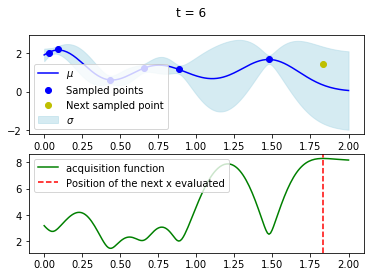

0.212285578250885 1.6106739044189453 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

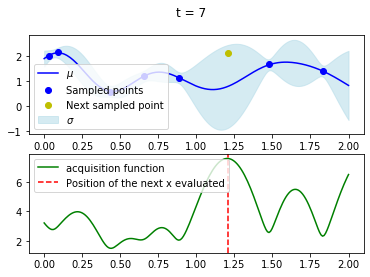

0.2135714292526245 1.7585983276367188 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

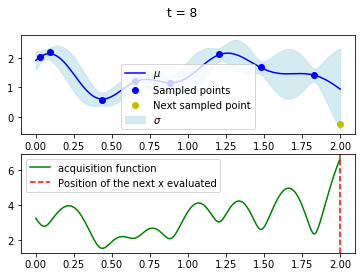

0.200124591588974 1.8010185956954956 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

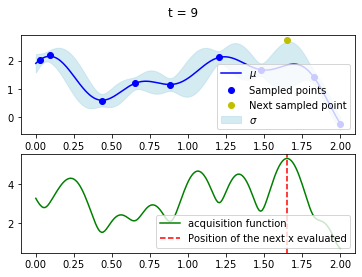

0.18970158696174622 1.9332451820373535 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

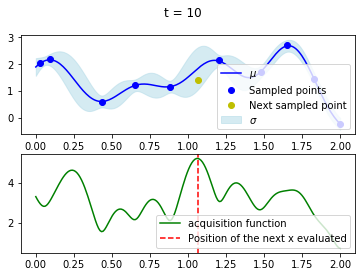

0.1873263269662857 1.869372010231018 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

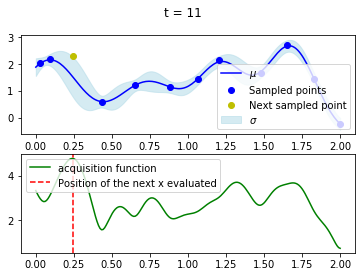

0.1865752637386322 2.01438307762146 0.01000281423330307


<Figure size 864x576 with 0 Axes>

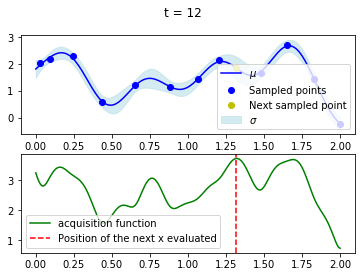

0.19378629326820374 2.10402512550354 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

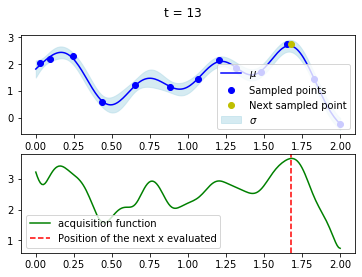

0.20191214978694916 2.151395797729492 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

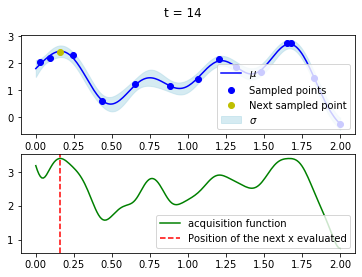

0.20711295306682587 2.232933759689331 9.999999747378752e-06


<Figure size 864x576 with 0 Axes>

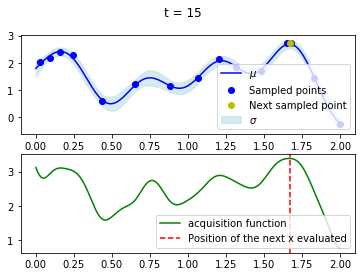

0.1948353350162506 1.957116961479187 0.02552863396704197


<Figure size 864x576 with 0 Axes>

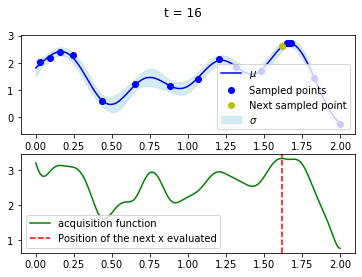

0.19511903822422028 1.947104573249817 0.022328685969114304


<Figure size 864x576 with 0 Axes>

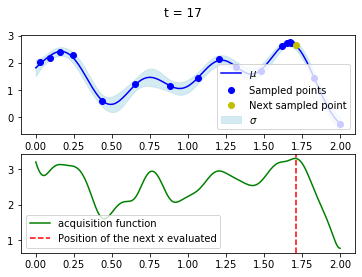

0.196456179022789 1.9377481937408447 0.044379234313964844


<Figure size 864x576 with 0 Axes>

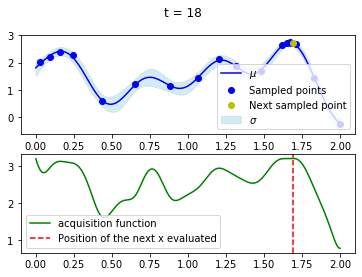

0.19656115770339966 1.929599642753601 0.04712768644094467


<Figure size 864x576 with 0 Axes>

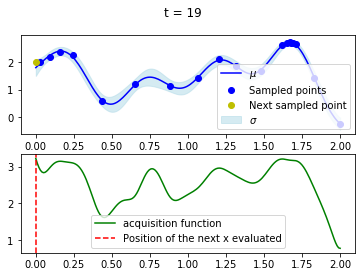

0.1965416520833969 1.942370057106018 0.046929311007261276


<Figure size 864x576 with 0 Axes>

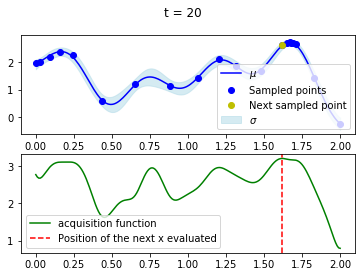


 Candidates for the maximum of the function are:
X's:  [0.4321608040201005, 0.8844221105527639, 1.4773869346733668, 0.03015075376884422, 0.09045226130653267, 0.6532663316582915, 1.829145728643216, 1.206030150753769, 2.0, 1.6482412060301508, 1.065326633165829, 0.24120603015075376, 1.3165829145728642, 1.678391959798995, 0.16080402010050251, 1.6683417085427137, 1.6180904522613067, 1.7085427135678393, 1.6884422110552764, 0.0, 1.6180904522613067]
Respective y's:  [0.5912372140881836, 1.1540198704489457, 1.683161357014842, 2.0226588105204266, 2.1910804139534603, 1.2211286840101783, 1.4321309808341036, 2.135983962519862, -0.24011590557239176, 2.723123716002883, 1.4253040431050548, 2.2864373952190995, 1.8607838085116044, 2.72849885589159, 2.3989785317624195, 2.7466128799535974, 2.6327048727978153, 2.6750087679425967, 2.70721745929315, 1.9964365619581592, 2.6064456954187256]
--------------
The max of the function found by the algorithm is:  2.7466128799535974
The maximum is at x = 1.6683417085

In [10]:
from ipynb.fs.full.unknown_objective import query_the_objective, plot_the_unknown_function, get_the_true_max 
np.random.seed(32)
# points that we are considering
X = np.linspace(0,2,200)

# prior over the lengthscale
prior_mean = -1.5 
priot_std = 0.6

# array for the points x' and repective f(x') that we sample using the acquisition function
X_sample = []
y_sample = []

# number of iterations
T = 15

# number of initial random samples
init_samples = 6

# trade-off hyperparams
eps = 0.5

# get some random samples
for _ in range(init_samples):
    # sample a point at random
    xt = X[np.random.randint(0, len(X))]
    # evaluate the point
    X_sample.append(xt)
    # we query the function
    y_sample.append(query_the_objective(xt))
    
    
# bayesian optimization loop
# compute the current best 
current_best = np.max(y_sample)

# loop

for t in range(len(X_sample),len(X_sample) + T):
    ## we should optimize the GP hyperparameters before fitting the final GP and computing the acquisition
    ## functions
    lengthscale, output_variance, noise_variance = optimize_GP_hyperparams(X_sample, y_sample, 1000, 5e-3, prior_mean, prior_std)
    print(lengthscale, output_variance, noise_variance)
    # we have to fit the GP using the X_sample, Y_sample and our training point
    mu, covariance = fit_predictive_GP(X_sample, y_sample, X, lengthscale, output_var, noise_var)
    # get the standard deviation
    std = np.sqrt(np.diag(covariance))

    
    ## calculate acquisition values for your acquisition function of choice
    acquisition_values = GP_UCB_original( mu, std, t, delta = 0.1)
#    probability_of_improvement
    
    # we have to find the xt that maximizes this acquisition function
    xt = X[np.argmax(acquisition_values)]


    ## now we should create the plots
    if t > 0:
        plt.figure(figsize=(12, 8))
        fig, axs = plt.subplots(2)
        fig.suptitle(f't = {t}')
        axs[0].fill_between(X.flat, mu - std, mu + std,  color='lightblue', alpha=0.5, label = r"$\sigma$")
        # axs[0].fill_between(X.flat, mu - noise_, mu + noise_, color='red', alpha=0.4, label=r"predictive")
        axs[0].plot(X, mu, 'b-', label=r'$\mu$')

        if len(X_sample) > 0:
            axs[0].plot(X_sample, y_sample, 'bo', label='Sampled points')
        axs[0].plot(xt, query_the_objective(xt), 'yo', label='Next sampled point')
        axs[0].legend()

        #plot acquisition
        axs[1].plot(X, acquisition_values, '-', color = 'green', label = 'acquisition function')
        axs[1].axvline(xt, color = 'red', linestyle = '--', label='Position of the next x evaluated')
        axs[1].legend()
        plt.show()

    # we compute the value of xt and we add xt and f(xt) in X_samples and y_samples
    X_sample.append(xt)
    # we append a noisy observation (should we?)
    y_sample.append(query_the_objective(xt))

    # update current best
    current_best = np.max(y_sample)
    
    
print('\n Candidates for the maximum of the function are:')
print("X's: ", X_sample)
print("Respective y's: ", y_sample)
print('--------------')
print('The max of the function found by the algorithm is: ', np.max(y_sample))
get_the_true_max() 

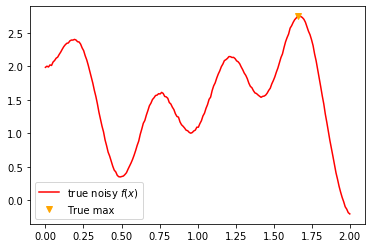

In [7]:
plot_the_unknown_function()